# Построение модели прогнозирования обращений в лечебные учреждения.

## Формулировка задачи:
Требуется обучить модель предсказания факта обращения застрахованного в январе 2022. Т.е., требуется классифицировать застрахованных на 2 класса: 1 - застрахованный обратился в январе 2022 года, 0 - застрахованный не обратился в январе 22 года.

Представленны данные об обращении застрахованных по ДМС в лечебные учреждения за 2021 год с указанием даты обращения, количества полученных медицинских услуг и их суммарной стоимости. Кроме того, доступна информация о поле и возрасте пациентов.

Последовательность решения задачи:
1. Загрузка и анализ данных.
2. Подготовка данных.
3. Обучение и выбор моделей.
4. Тестирование модели.
5. Вывод.

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

pd.set_option('display.max_columns', None)
%matplotlib inline
import gc

In [2]:
# Константы
SEED = 5555

## 1. Загрузка и анализ данных

### 1.1 Загрузка данных и первый взгляд

In [3]:
# Загрузим набор данных и преобразуем колонку с датами в формат datetime
df = pd.read_csv('MainsLab_data_DS_22.csv', parse_dates=['service_date'])

In [4]:
df.head(10)

,insured,service_date,sex_id,age_for_service_date,serv_count,serv_amount
0,125045,2021-03-03,1.0,6,2.0,2260.0
1,125045,2021-04-11,1.0,6,1.0,1600.0
2,125045,2021-04-18,1.0,6,5.0,4510.0
3,125045,2021-04-23,1.0,6,1.0,380.0
4,125045,2021-06-09,1.0,6,1.0,2500.0
5,125045,2021-11-24,1.0,7,2.0,4100.0
6,125045,2022-01-17,1.0,7,6.0,6540.0
7,125046,2021-06-15,2.0,28,2.0,2610.0
8,125046,2021-06-17,2.0,28,5.0,2410.0
9,125046,2021-06-18,2.0,28,1.0,1300.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764333 entries, 0 to 764332
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   insured               764333 non-null  int64         
 1   service_date          764333 non-null  datetime64[ns]
 2   sex_id                764129 non-null  float64       
 3   age_for_service_date  764333 non-null  int64         
 4   serv_count            764333 non-null  float64       
 5   serv_amount           764333 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 35.0 MB


In [6]:
df.describe()

,insured,sex_id,age_for_service_date,serv_count,serv_amount
count,7.643330e+05,764129.000000,764333.000000,764333.000000,764333.000000
mean,4.730479e+05,1.653746,34.925981,2.360192,2242.992679
std,1.959460e+05,0.475776,16.035400,4.479210,2877.117835
min,1.250450e+05,1.000000,0.000000,0.000000,0.000000
25%,2.658610e+05,1.000000,28.000000,1.000000,921.000000
50%,5.167940e+05,2.000000,36.000000,1.000000,1450.000000
75%,6.284420e+05,2.000000,45.000000,3.000000,2610.000000
max,1.226151e+06,2.000000,120.000000,2103.000000,386800.000000


In [7]:
print('количество дубликатов =', df.duplicated().sum())

количество дубликатов = 52


In [8]:
# Рассмотрим дубликаты ближе
df[df.duplicated()].head()

,insured,service_date,sex_id,age_for_service_date,serv_count,serv_amount
13059,146008,2021-03-25,2.0,44,1.0,1500.0
32378,159039,2021-02-18,2.0,44,2.0,2160.0
63032,178089,2021-01-22,2.0,31,1.0,1600.0
64365,178732,2021-08-14,2.0,31,2.0,1080.0
71397,185867,2021-03-27,2.0,39,1.0,2800.0


In [9]:
# Возьмём один дубликат и посмотрим на него в контексте остальных строк по данному клиенту
df[df['insured'] == 146008]

,insured,service_date,sex_id,age_for_service_date,serv_count,serv_amount
13054,146008,2021-01-14,2.0,44,5.0,3610.0
13055,146008,2021-01-20,2.0,44,2.0,2600.0
13056,146008,2021-01-28,2.0,44,1.0,1100.0
13057,146008,2021-03-22,2.0,44,1.0,1500.0
13058,146008,2021-03-25,2.0,44,1.0,1500.0
13059,146008,2021-03-25,2.0,44,1.0,1500.0
13060,146008,2021-03-26,2.0,44,2.0,2200.0
13061,146008,2021-03-29,2.0,44,1.0,1100.0
13062,146008,2021-04-06,2.0,44,1.0,1100.0


**Вывод:** 
1. Данные загружены.
2. Пропуски присутствуют в колонке `sex_id`.
3. Присутствуют полные дубликаты строк. Это два обращения одного и того-же клиента в один день или ошибка?

### 1.2 Рассмотрим датасет ближе

Каждая стока набора данных характеризует обращение за медицинской помощью одного клиента в определённую дату(количество и стоимость обращений).

#### 1.2.1 Уникальный ид застрахованного лица

In [10]:
df['insured'].value_counts().describe()

count    137645.000000
mean          5.552930
std           6.438355
min           1.000000
25%           1.000000
50%           3.000000
75%           7.000000
max         113.000000
Name: insured, dtype: float64

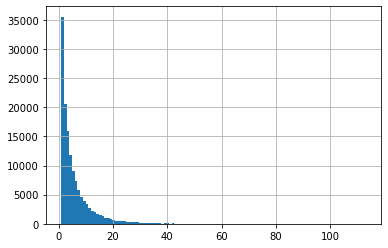

In [11]:
df['insured'].value_counts().hist(bins=113);

**Вывод:** В наборе данных содержаться сведенья о 137645 клиентах. Большинство из них обращались за медицинской помощью 1-3 раза. Но есть и некоторые клиенты, которые обращались более 100 раз.

#### 1.2.2 Пол застрахованного

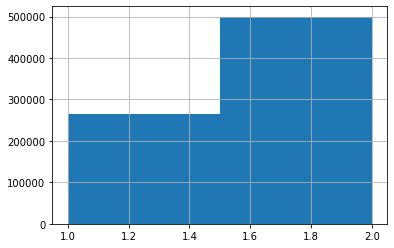

In [12]:
df['sex_id'].hist(bins=2);

**Вывод:** Данные о поле клиентов распределены в отношении 1 к 2.

#### 1.2.3 Дата оказания услуги

In [13]:
df['service_date'].min()

Timestamp('2021-01-01 00:00:00')

In [14]:
df['service_date'].max()

Timestamp('2022-01-31 00:00:00')

Даты обращений лежат в диапозоне 1 января 2021 года - 31 января 2022 года.

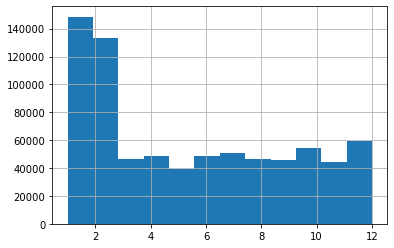

In [15]:
df['service_date'].dt.month.hist(bins=12);

In [16]:
df[df['service_date'].dt.month == 2]['service_date'].count()

133304

In [17]:
df[df['service_date'].dt.month == 1]['service_date'].dt.year.value_counts()

2021    101596
2022     46943
Name: service_date, dtype: int64

По месяцам обращения за медицинской помощью для периода с марта 2021г. по январь 2022г. лежат в диапозоне от 40000 до 60000
Январь и февраль 2021 года выбиваются из этого распределения со 101596 и 133304 соответственно. Возможно в эти месяцы ещё не пропало влияние пандемии коронавируса.

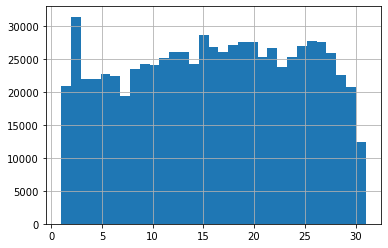

In [18]:
df['service_date'].dt.day.hist(bins=31);

По дням внутри месяца количество обращений распределено прауктически равномерно. Разве что выбивается число 2, но не значительно.

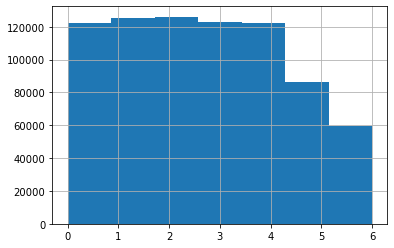

In [19]:
df['service_date'].dt.dayofweek.hist(bins=7);

По дням недели распределение обращений вполне закономерно. В буднии дни обращений поровну, в субботу меньше в воскресенье ещё меньше. Это обьясняется тем, что в будни осуществляется как плановый приём так и приём по для оказания неотложной медицинской помощи. Выходные обращаются, как правило, только за экстренной помощью.

#### 1.2.4 Возраст застрахованного на дату оказания услуги

<AxesSubplot:>

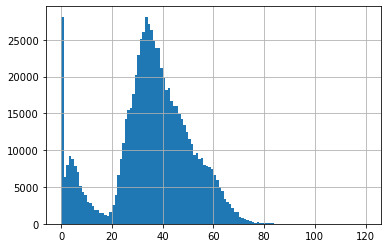

In [20]:
df['age_for_service_date'].hist(bins=120)

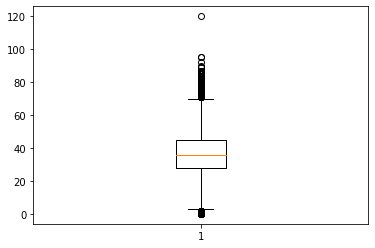

In [21]:
plt.boxplot(df['age_for_service_date']);

In [22]:
df['age_for_service_date']

0          6
1          6
2          6
3          6
4          6
          ..
764328    29
764329    29
764330    29
764331    58
764332    58
Name: age_for_service_date, Length: 764333, dtype: int64

**Вывод:** 
1. Возраст клиентов лежит в диапозоне от 0 до 120 лет.
2. 120 - это скорее всего ошибка в данных. Возможно это 12 лет.
3. Слишком много нулевых значений. Возможно большая часть нулевых значений - это пропуски возраста.
4. Распределение клиентов по возрасту довольно интересное. Больнинство клиентов имеют возраст от 28 до 45 лет. Средний возраст клиентов = 35 лет. Также, много клиентов с нулевым возрастом. Это говорит но том, что очень часто обращаются за мед помощью родители новорожденных. Далее, имеется локальный максимум обращений в возрасте около пяти лет, со спадом активности до совершеннолетия. Далее идёт возрастание обращений.

#### 1.2.5 Количество оказанных услуг

<AxesSubplot:>

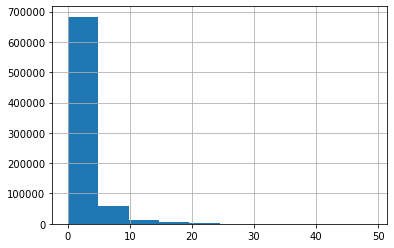

In [23]:
# df['serv_count'].hist()
df[df['serv_count'] < 50]['serv_count'].hist()

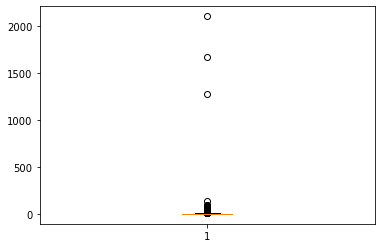

In [24]:
plt.boxplot(df['serv_count']);

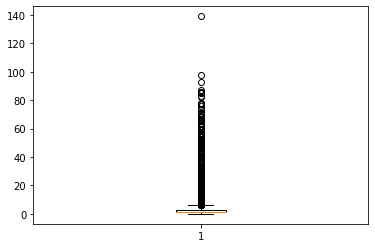

In [25]:
plt.boxplot(df[df['serv_count'] < 500]['serv_count']);

In [26]:
# Посмотрим на записи где количество услуг = 0
df[df['serv_count'] == 0]

,insured,service_date,sex_id,age_for_service_date,serv_count,serv_amount
153771,235243,2021-04-10,2.0,37,0.0,855.0
167522,244392,2021-04-30,2.0,29,0.0,855.0


**Вывод:** Большинство клиентов обращались за помощью в один день от 1 до 3 раз. Однако в наборе данных присутствуют записи об обращениях в одну дату до 2610 раз. Это, мягко говоря, сомнительно. Возможно, в данном наборе данных эта колонка содержит не только количество обращений в день, но и какие-либо другие значения? Например количество медицинских препаратов, израсходованных для лечения клиента? Или их объём? Также, вызывают вопросы нулевые значения в данной колонке. Это обращение застрахованног, но услуга не была оказана? Но стоимость услуг не нулевая - скорее всего это ошибка. 

#### 1.2.6 Суммарная цена оказанных услуг

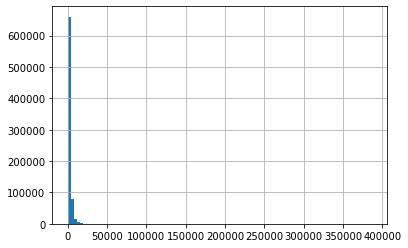

In [27]:
df[df['serv_amount'] < 500000]['serv_amount'].hist(bins=100);

In [28]:
df[df['serv_amount'] > 200000]

,insured,service_date,sex_id,age_for_service_date,serv_count,serv_amount
60170,176296,2021-01-08,1.0,62,2.0,276962.73
60195,176296,2021-02-12,1.0,62,3.0,274593.26
351879,501588,2021-01-22,2.0,24,20.0,386800.00


In [29]:
df[df['insured'] == 501588]

,insured,service_date,sex_id,age_for_service_date,serv_count,serv_amount
351878,501588,2021-01-12,2.0,24,2.0,2100.0
351879,501588,2021-01-22,2.0,24,20.0,386800.0
351880,501588,2021-02-17,2.0,24,10.0,5200.0
351881,501588,2021-04-23,2.0,25,1.0,1500.0
351882,501588,2021-05-24,2.0,25,1.0,1500.0
351883,501588,2021-05-25,2.0,25,1.0,1400.0
351884,501588,2021-05-31,2.0,25,1.0,1500.0
351885,501588,2021-06-04,2.0,25,2.0,2490.0
351886,501588,2021-06-07,2.0,25,1.0,990.0
351887,501588,2021-10-20,2.0,25,1.0,1500.0


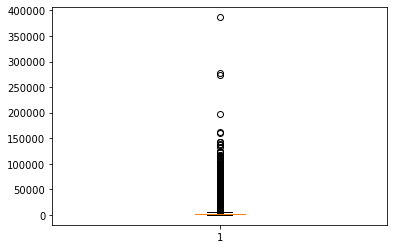

In [30]:
plt.boxplot(df['serv_amount']);

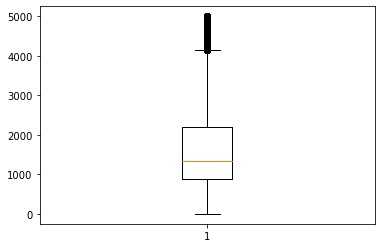

In [31]:
plt.boxplot(df[df['serv_amount'] < 5000]['serv_amount']);

**Вывод:** Для большинства обращений, стоимость медицинских услуг лежит в диапозоне 900-2600. В некоторых случаях стоимость достигает очень больших значений- до 400000. Это ошибки или дорогостиящие операции?

#### 1.2.7 Построим матрицу корреляций

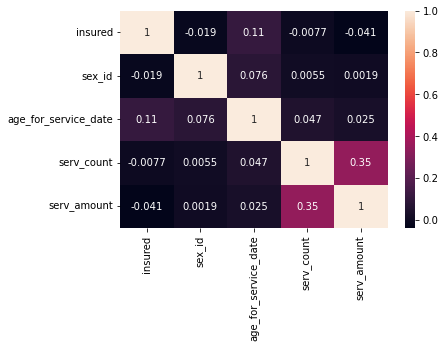

In [32]:
sns.heatmap(df.corr(), annot=True);

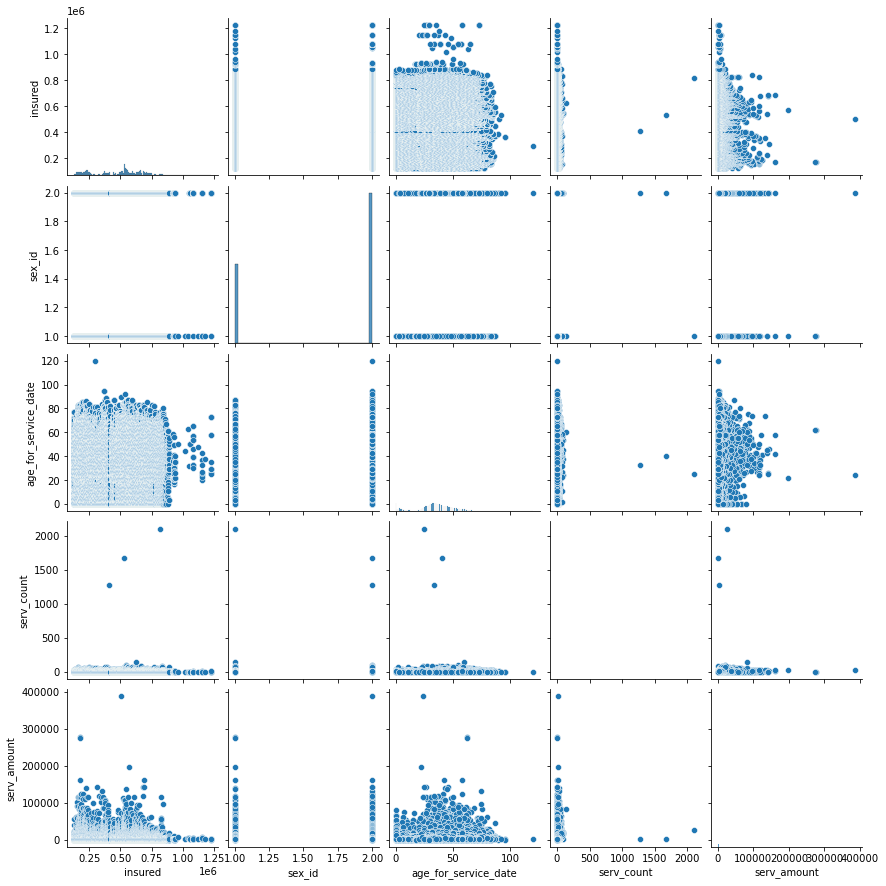

In [33]:
sns.pairplot(df);

**Вывод:** Сильных корреляционных зависимостей между значениями в разных колонках датасета не обнаружено.

**Вывод по разделу**
1. Набор данных содержит сведенья об обращении застрахованных по ДМС в лечебные учреждения в период с 01 января 2021 года по 31 января 2022 года.
2. В наборе данных содержаться сведенья о 137645 клиентах. Большинство из них обращались за медицинской помощью 1-3 раза за вышеуказанный период. Но есть и некоторые клиенты, которые обращались более 100 раз.
3. Большинство клиентов в один день получили от 1 до 3 услуг. Однако в наборе данных присутствуют записи о получении в одну дату до 2610 услуг. Также присутствуют нулевые значения. Не понятно что считается услугой? Это количество обращений к врачу или количество потраченных ресурсов на пациента?
4. Для большинства клиентов, стоимость медицинских услуг за один день лежит в диапозоне 900-2600. В некоторых случаях стоимость достигает очень больших значений- до 400000. Это ошибки или дорогостиящие операции?
5. Данные о поле клиентов распределены в отношении 1 к 2.
6. Распределение клиентов по возрасту довольно интересное. Больнинство клиентов имеют возраст от 28 до 45 лет. Средний возраст клиентов = 35 лет. Также, много клиентов с нулевым возрастом. Это говорит но том, что очень часто обращаются за мед помощью родители новорожденных. Далее, имеется локальный максимум обращений в возрасте около пяти лет, со спадом активности до совершеннолетия. Далее идёт возрастание обращений до 35 лет с последующим спадом. Присутствуют клиенты с возрастом 120 лет - возможно это ошибка.
7. Пропуски присутствуют в колонке `sex_id`.
8. Присутствует 52 полных дубликата строк. Скорее всего - это ошибка ввода данных, которую следует удалить. Однако, возможно, это два обращения за один день.
9. Сильные корреляционные зависимостей между значениями в разных колонках датасета отсутствуют.

По результатам анализа данных, для лучшего понимания данных и более качественной обработки и будущей модели, необходимо задать следующие вопросы тому, кто составлял датасет:
1. Как формировалась колонка с количеством услуг? Являются-ли нормальными данные с очень большим количеством услуг?
2. До каких пределов может доходить стоимость услуг?
3. Правда-ли существует клиент с возрастом 120 лет или это ошибка. Большое количество клиентов с нулевым возрастом - это достоверные сведенья, или это пропуски истинных значений?
4. Дубликаты строк - это ошибки или два обращения в один день?

## 2. Подготовка данных

1. Предобработка.
    - Дубликаты - удалить
    - Обработка пропусков.
    - Выбросы - обработать
2. Генерация доп признаков:
    - Признаки на основе даты обращения
    - Целевой признак
3. Группировка по ID клиента и извлечение признаков
4. Формирование выборок.

### 2.1 Предобработка
    - Удалим дубликаты
    - Обработаем пропуски. Так как восстановить значения неоткуда, заполним наиболее частым значением.
    - Обработаем выбросы. Удалим только самые большие выбросы в колонках `serv_amount` и `serv_count`.
    - Обработаем недостоверные данные

In [34]:
# Удалим дубликаты
df = df.drop_duplicates()

In [35]:
# Заполним пропуски наиболее частым значением
df['sex_id'] = df['sex_id'].fillna(2)

In [36]:
# Обработка выбросов
df = df[df['serv_amount'] < 200000]
df = df[df['serv_count'] < 500]

In [37]:
# Заменим на 1 количество услуг равное нулю
df.loc[df['serv_count'] == 0, 'serv_count'] = 1

**Вывод:** Дубликаты удалены, пропуски заполнены, выбросы обработаны.

### 2.2 Генерация признаков

В данный момент, в исходном наборе данных имеется информация об обращениях за медпомощью застрахованных. Для прогнозирования обращений на следующий месяц, информацию об обращениях каждого клиента необходимо рассматривать как временной ряд. Прблема заключается в том, что количество обращений у разных клиентов различно, а для подачи в модель машинного обучения данные по каждому клиенту должны иметь одинаковый формат. Так как нам необходимо прогнозировать на один месяц вперёд, за единицу времени примем один месяц.

1. Для того, чтобы модель не была привязана к конкретным датам, преобразуем данные о времени обращений в "относительные месяцы". Последнй месяц в наборе данных будет иметь наименование `0`, предыдущий `-1` и так далее.
2. Преобразуем данные таким образом, что каждая строка будет отражать не отдельное обращение, а все обращения за месяц. Таким образом, для каждого клиента в наборе данных будет столько строк, сколько месяцев присутствует в датафрейме.
3. Затем, будем работать с записями по каждому клиенту, как с временным рядом, а именно:
    - Сгенерируем признаки сдвигов для колоноки `serv_amountsum`.
    - Сгенерируем признак скользящее среднее по этой-же колонке.
    - Значение максимального сдвига и окна скользящего среднего определим эксперементальным путём
4. В процессе такого формирования признаков, неизбежно возникнут строки с пропущенными значениями. И их будет тем больше, чем большие значения максимального сдвига и окна скользящего среднего. Такие строки придётся удалить.
5. Выделим целевой признак для каждой записи: `1` - если были оказаны услуги в следующем месяце, `0` - нет.
6. Для последнего месяца целевого признака не будет. Строки по последнему месяцу можно исспользовать для проверки работы модели на тестовой выборке, если есть данные за февраль 2022 года.


#### 2.2.1 Переход к набору данных по месяцам

In [38]:
# Месяц
df['month'] = df['service_date'].dt.month
# Год
df['year'] = df['service_date'].dt.year

In [39]:
# Признак цена единицы мед услуг
df['serv_amuont_perone'] = df['serv_amount'] / df['serv_count']

In [40]:
# Для дальнейшей работы на м понадобяться значения максимального года и месяца в наборе данных
MAX_YEAR = df['year'].max()
MAX_MONTH = df['service_date'].max().month

In [41]:
# Перейдём на относительное летоисчесление
df['year'] = df['year'] - MAX_YEAR
df['month'] = df[['month','year']].apply(lambda x: x.year * 12 + x.month - MAX_MONTH, axis=1)

df.head()

,insured,service_date,sex_id,age_for_service_date,serv_count,serv_amount,month,year,serv_amuont_perone
0,125045,2021-03-03,1.0,6,2.0,2260.0,-10,-1,1130.0
1,125045,2021-04-11,1.0,6,1.0,1600.0,-9,-1,1600.0
2,125045,2021-04-18,1.0,6,5.0,4510.0,-9,-1,902.0
3,125045,2021-04-23,1.0,6,1.0,380.0,-9,-1,380.0
4,125045,2021-06-09,1.0,6,1.0,2500.0,-7,-1,2500.0


In [42]:
# С помощью группировки по индексу клиента и месяцу, произведём переход к данным "по месяцам"
agg_month = {'sex_id':['max','count'],
             'age_for_service_date':'median',
             'serv_count':'sum',
             'serv_amount':'sum',
             'serv_amuont_perone':'mean',
}

In [43]:
df_month = df.groupby(['insured','month']).agg(agg_month).reset_index()
# Переименуем колонки и приведём их к одноуровневому формату
# df_month.columns = [''.join(i) for i in df_month.columns]
df_month.columns = ['insured',
                    'month',
                    'sex_id',
                    'count',
                    'age_for_service_date',
                    'serv_count_sum',
                    'serv_amount_sum',
                    'serv_amuont_perone_mean'
]
df_month.head()

,insured,month,sex_id,count,age_for_service_date,serv_count_sum,serv_amount_sum,serv_amuont_perone_mean
0,125045,-10,1.0,1,6.0,2.0,2260.0,1130.000000
1,125045,-9,1.0,3,6.0,7.0,6490.0,960.666667
2,125045,-7,1.0,1,6.0,1.0,2500.0,2500.000000
3,125045,-2,1.0,1,7.0,2.0,4100.0,2050.000000
4,125045,0,1.0,1,7.0,6.0,6540.0,1090.000000


**Вывод:** Теперь в датасете не записи по отдельным обращениям, а записи по обращениям за месяц.

#### 2.2.2 Выделение признаков

1. На данные момент в датасете отсутствуют записи по месяцам, в которые застрахованый не обращался за медпомощью. Исправим это.
2. Выделим признаки временных рядов.

In [44]:
# Подготовка признаков временного ряда

def make_features(data, features=['serv_amount_sum', 
                                  # 'count', 
                                  # 'serv_count_sum'
                                 ],
                  max_lag=10, 
                  rolling_mean_size=10
                 ):
    """ Принимаем данные, максимальный сдвиг и окно для скользящего среднего
        Создаём признаки и записываем результаты напрямую в датафрейм
    """
    data = pd.DataFrame(data)
    
    for feature in features:
        # Создание признаков сдвига
        for lag in range(1, max_lag + 1):
            data['{}_lag_{}'.format(feature, lag)] = data[feature].shift(lag)
        # Создание скользящего среднего
        data['rolling_mean_{}'.format(feature)] = data[feature].shift().rolling(rolling_mean_size).mean()
    return data

In [45]:
def last_service_calc(data):
    """ Принимаем колонку с целевой переменной
        Возвращаем колонку с количеством месяцев прошедших с последнего посещения
    """
    result = []
    it = 0
    for i in range(len(data)):
        it += 1
        result.append(it)
        if data[i] == 1:
            it = 0
    return result

In [46]:
def сlient_process(data):
    """ Принимаем данные, которые необходимо преобразовать - данные по одному клиенту
        Возвращаем преобразованные данные, приведённые единому стандарту по всем месяцам(даже если в этот месяц клиент не обращался),
        и с извлечёнными признаками временных рядов.
    """
    # Создаём "заготовку" - пустой датафрейм, но зато со всеми возможными месяцами
    result = pd.DataFrame({'month':range(df['month'].min(),1)})
    # result = blanc.copy()
    # К заготовке мерджим поступившие данные. Таким образом получаем пустые строки для месяцев в которых нет обращений и заполненные в которых были
    result = result.merge(data, how='left', on='month')
    # Заполняем пропуски
    # В колонках "индекс", "пол" и "возраст" - соседними значениями
    result[['insured','sex_id','age_for_service_date']] = result[['insured','sex_id','age_for_service_date']].ffill().bfill()
    # В остальных - нулями
    result = result.fillna(0)
    # Вызываем функцию создания признаков временных рядов
    result = make_features(result)
    # Выделяем целевой признак из будущего месяца
    result['label'] = [_ for _ in (result.loc[1:, 'serv_amount_sum'] > 0)*1] + [9999]
    # Рассчитываем сколько месяцев назад было последнее обращение
    result['last_serv_month_ago'] = last_service_calc(result['label'])
    
    
    return result


In [47]:
%%time
# Запускаем преобразование данных и извлечение признаков
df_final = df_month.groupby('insured').apply(сlient_process)


df_final = df_final.reset_index(drop=True)
df_final.head(20)

CPU times: total: 12min 44s
Wall time: 12min 45s


,month,insured,sex_id,count,age_for_service_date,serv_count_sum,serv_amount_sum,serv_amuont_perone_mean,serv_amount_sum_lag_1,serv_amount_sum_lag_2,serv_amount_sum_lag_3,serv_amount_sum_lag_4,serv_amount_sum_lag_5,serv_amount_sum_lag_6,serv_amount_sum_lag_7,serv_amount_sum_lag_8,serv_amount_sum_lag_9,serv_amount_sum_lag_10,rolling_mean_serv_amount_sum,label,last_serv_month_ago
0,-12,125045.0,1.0,0.0,6.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1,-11,125045.0,1.0,0.0,6.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2
2,-10,125045.0,1.0,1.0,6.0,2.0,2260.0,1130.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
3,-9,125045.0,1.0,3.0,6.0,7.0,6490.0,960.666667,2260.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
4,-8,125045.0,1.0,0.0,6.0,0.0,0.0,0.000000,6490.0,2260.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2
5,-7,125045.0,1.0,1.0,6.0,1.0,2500.0,2500.000000,0.0,6490.0,2260.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1
6,-6,125045.0,1.0,0.0,6.0,0.0,0.0,0.000000,2500.0,0.0,6490.0,2260.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,2
7,-5,125045.0,1.0,0.0,6.0,0.0,0.0,0.000000,0.0,2500.0,0.0,6490.0,2260.0,0.0,0.0,NaN,NaN,NaN,NaN,0,3
8,-4,125045.0,1.0,0.0,6.0,0.0,0.0,0.000000,0.0,0.0,2500.0,0.0,6490.0,2260.0,0.0,0.0,NaN,NaN,NaN,0,4
9,-3,125045.0,1.0,0.0,6.0,0.0,0.0,0.000000,0.0,0.0,0.0,2500.0,0.0,6490.0,2260.0,0.0,0.0,NaN,NaN,1,5


In [49]:
# Удалим строки с пропусками
df_final = df_final.dropna()
df_final.head(10)

,month,insured,sex_id,count,age_for_service_date,serv_count_sum,serv_amount_sum,serv_amuont_perone_mean,serv_amount_sum_lag_1,serv_amount_sum_lag_2,serv_amount_sum_lag_3,serv_amount_sum_lag_4,serv_amount_sum_lag_5,serv_amount_sum_lag_6,serv_amount_sum_lag_7,serv_amount_sum_lag_8,serv_amount_sum_lag_9,serv_amount_sum_lag_10,rolling_mean_serv_amount_sum,label,last_serv_month_ago
10,-2,125045.0,1.0,1.0,7.0,2.0,4100.0,2050.000000,0.0,0.0,0.0,0.0,2500.0,0.0,6490.0,2260.0,0.0,0.0,1125.0,0,1
11,-1,125045.0,1.0,0.0,7.0,0.0,0.0,0.000000,4100.0,0.0,0.0,0.0,0.0,2500.0,0.0,6490.0,2260.0,0.0,1535.0,1,2
12,0,125045.0,1.0,1.0,7.0,6.0,6540.0,1090.000000,0.0,4100.0,0.0,0.0,0.0,0.0,2500.0,0.0,6490.0,2260.0,1535.0,9999,1
23,-2,125046.0,2.0,4.0,29.0,24.0,20930.0,1014.318182,14990.0,0.0,0.0,0.0,6320.0,0.0,0.0,0.0,0.0,0.0,2131.0,1,1
24,-1,125046.0,2.0,2.0,29.0,2.0,2600.0,1300.000000,20930.0,14990.0,0.0,0.0,0.0,6320.0,0.0,0.0,0.0,0.0,4224.0,0,1
25,0,125046.0,2.0,0.0,29.0,0.0,0.0,0.000000,2600.0,20930.0,14990.0,0.0,0.0,0.0,6320.0,0.0,0.0,0.0,4484.0,9999,2
36,-2,125047.0,2.0,0.0,53.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,7060.0,0.0,0.0,0.0,0.0,0.0,706.0,0,6
37,-1,125047.0,2.0,0.0,53.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,7060.0,0.0,0.0,0.0,0.0,706.0,0,7
38,0,125047.0,2.0,0.0,53.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,7060.0,0.0,0.0,0.0,706.0,9999,8
49,-2,125048.0,1.0,5.0,18.0,20.0,28040.0,1925.000000,33540.0,0.0,11600.0,5840.0,7460.0,22030.0,0.0,9370.0,3400.0,0.0,9324.0,1,1


In [50]:
# Случайный признак для оценки важности признаков
df_final['random'] = np.random.rand(df_final.shape[0])

**Вывод** 
1. Перешли от данных учитывающих отдельные обращения к данным по месяцам.
2. Сформировали признаки временных рядов.
3. Сформировали колонку целевого признака.

Набор данных для обучения модели сформирован.

#### 2.2.3 Анализ признаков

Ароанализируем данные на наличие сильных корреляционных зависимостей.

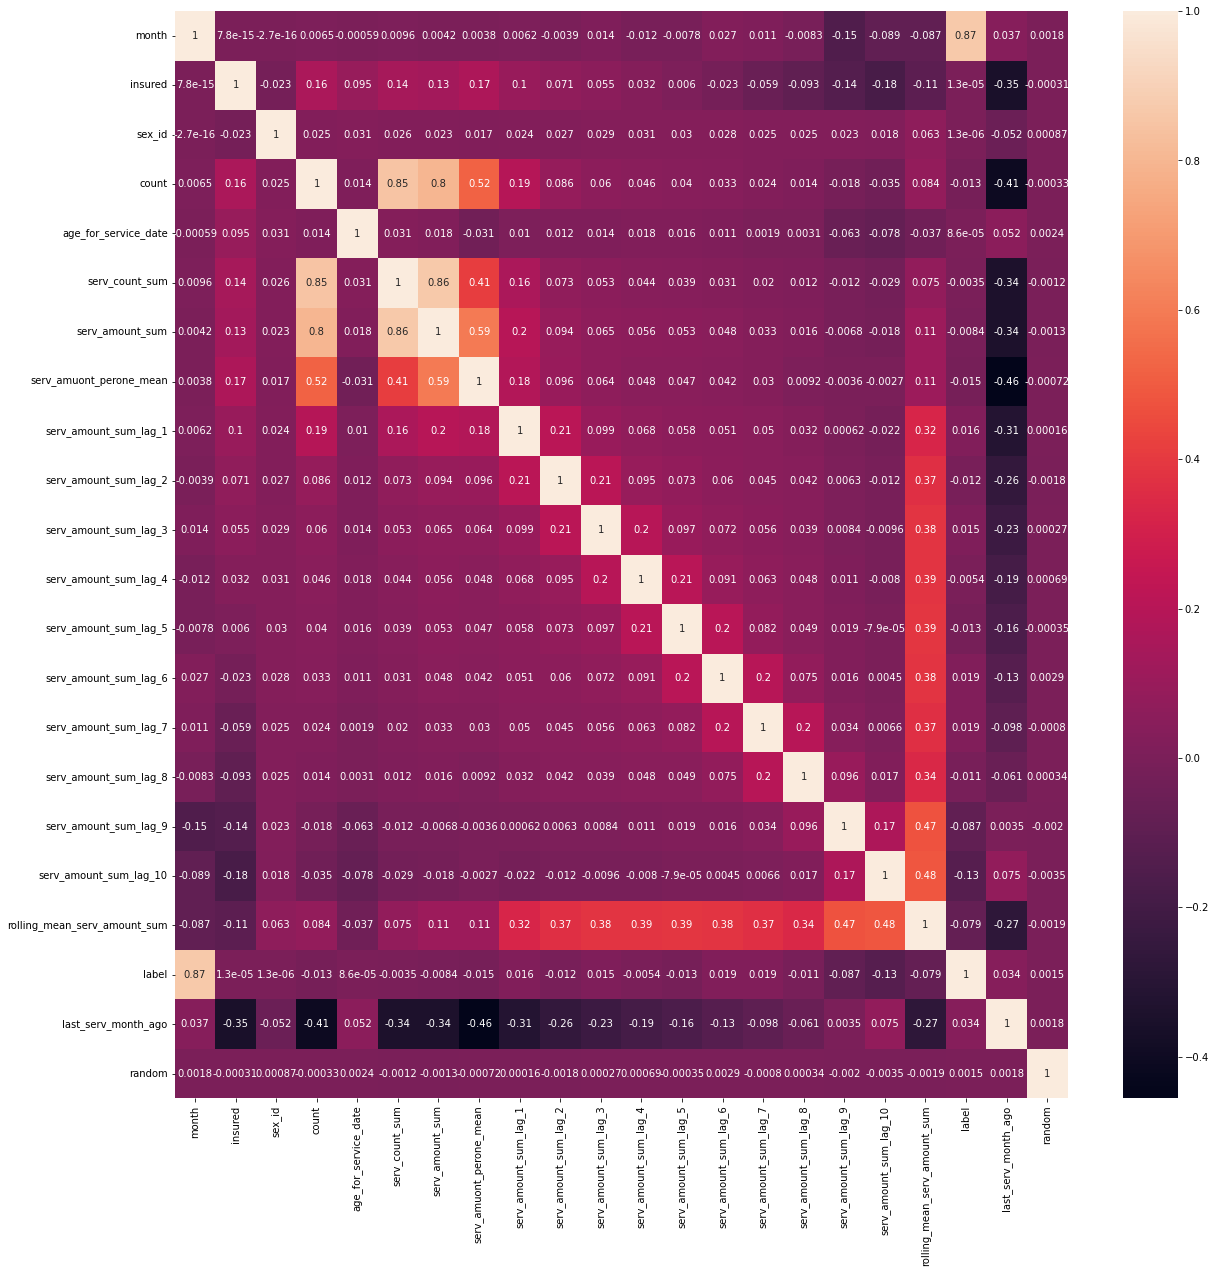

In [52]:
# Построим корреляционную матрицу
plt.rcParams['figure.figsize']=(20,20)

sns.heatmap(df_final.corr(), annot=True);

**Вывод:** В результате анализа матрицы корреляции видно, что сильно коррелируют признаки `count`,`serv_count_sum`,`serv_amount_sum`. Для обучения модели будем использовать только один из них - `serv_amount_sum`. Также наблюдается сильная корреляция между целевой переменной и номером месяца. Номер месяца, также не будет использоваться для обучения модели.

### 2.3 Подготовка выборок для обучения модели

После всех преобразований, набор данных содержит информацию по состоянию на ноябрь 2021г., декабрь 2021г. и январь 2022г. Для обучения модели будем использовать данные на ноябрь. Данные на декабрь 2021г. будут использоватся для прогнозирования посещений в январе 2022г. Данные на январь 2022г можно использовать для прогнозирования посещений в феврале 2022 года. Валидационную выборку выделять не будем. Валидацию моделей в процессе её обучения и выбора будем осуществлять способом перекрёстной проверки.

In [54]:
# Данные за ноябрь будут обучающей выборкой
X_train = df_final[df_final['month'] < -1].drop(['label','insured','month','count','serv_count_sum'], axis=1)
y_train = df_final[df_final['month'] < -1]['label']

In [55]:
# Данные на декабрь будут тестовой выборкой
X_test = df_final[df_final['month'] == -1].drop(['label','insured','month','count','serv_count_sum'], axis=1)
y_test = df_final[df_final['month'] == -1]['label']

In [56]:
# Проверим размеры выборок
pd.DataFrame({'X_train':X_train.shape[0],
              'y_train':y_train.shape,
              'X_test':X_test.shape[0],
              'y_test':y_test.shape
})

,X_train,y_train,X_test,y_test
0,137644,137644,137644,137644


**Вывод:** Выборки сформированы. Получилось, что размер тренировочной и тестовой выборок равны. Это не совсем правильно, но опытным путём выяснилось, что решающее значение для качества будущей модели оказывает не размер обучающих данных, а максимальный размер сдвига и окна скользящего среднего. Увеличив размер данных, пришлось-бы уменьшать данные параметры, а это приводило к ухудшению качества.

**Вывод по разделу**

Произведена предобработка данных, выделены дополнительные признаки и целевой признак. Сформирован набор данных для обучения модели и подготовлены выборки



## 3. Обучение моделей

1. Обучим несколько моделей с подбором гиперпараметров
2. Выберем лучшую модель и протестируем её на отложенной тестовой выборке, а также проверим её работу на адекватность.

Так как присутствует сильный дисбалланс классов в целевой переменной, в дальнейшей работе в качестве метрики качества модели будем использовать ROC-AUC. Данная метрика отражает как точность, так и полноту классификации.

Для удобства работы создадим две функции:
1. Функцию возвращающую среднее значение метрики качества по результатам кросвалидации.
2. Функцию производящую подбор гиперпараметров и возвращающую метрику качества и гиперпараметры полученные на лучшей модели.

In [57]:
def get_quality(model, features_train=X_train, target_train=y_train):
    """ Принимаем модель и признаки,
        возвращаем ROC-AUC
    """
           
    return round(cross_val_score(model, features_train, target_train, n_jobs=-1, scoring='roc_auc').mean(), 3)

In [58]:
def get_params_cv(model, parametrs, features_train=X_train, target_train=y_train):
    """ Принимаем модель параметры для поиска параметров и признаки,
        возвращаем ROC-AUC и лучшие гиперпараметры
    """
    rs = RandomizedSearchCV(model, 
                            parametrs, 
                            scoring='roc_auc', 
                            cv=5,
                            random_state = SEED,
                            n_jobs=-1
                           )
    rs.fit(features_train, target_train)
    return round(rs.best_score_, 3), rs.best_params_

### 3.1 CatBoostClassifier

In [59]:
cat_clf = CatBoostClassifier(verbose=100,
                             auto_class_weights='Balanced',
                             random_state=SEED
                            )

get_quality(cat_clf)

0.775

In [60]:
%%time
params = {'l2_leaf_reg': range(10, 31),
          'learning_rate': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5],
          'depth' : range(3, 9)
}

get_params_cv(cat_clf, params)

0:	learn: 0.6927332	total: 177ms	remaining: 2m 56s
100:	learn: 0.6535272	total: 2.67s	remaining: 23.8s
200:	learn: 0.6223277	total: 5.14s	remaining: 20.4s
300:	learn: 0.5974570	total: 7.46s	remaining: 17.3s
400:	learn: 0.5775069	total: 9.78s	remaining: 14.6s
500:	learn: 0.5614442	total: 12.1s	remaining: 12.1s
600:	learn: 0.5485466	total: 14.5s	remaining: 9.61s
700:	learn: 0.5381597	total: 16.8s	remaining: 7.16s
800:	learn: 0.5296236	total: 19.4s	remaining: 4.81s
900:	learn: 0.5228230	total: 21.7s	remaining: 2.39s
999:	learn: 0.5172232	total: 24.1s	remaining: 0us
CPU times: total: 2min 47s
Wall time: 12min 20s


(0.834, {'learning_rate': 0.001, 'l2_leaf_reg': 27, 'depth': 8})

**Вывод:** На кросвалидации получили метрику качества ROC-AUC = 0.775. После подбора гиперпараметров качество улучшилось ROC-AUC  = 0.834.

### 3.2 LGBMClassifier

In [61]:
lgbm_clf = LGBMClassifier(class_weight='balanced', random_state=SEED)
get_quality(lgbm_clf)

0.794

In [62]:
%%time
params = { 'n_estimators': range(200, 401, 10),
           'learning_rate': [0.003, 0.005, 0.008, 0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.2, 0.5],
           'max_depth': range(20,70),
           'num_leaves': range(30,80),
}

get_params_cv(lgbm_clf, params)

CPU times: total: 8.41 s
Wall time: 45.5 s


(0.821,
 {'num_leaves': 30,
  'n_estimators': 210,
  'max_depth': 37,
  'learning_rate': 0.003})

**Вывод:** На кросвалидации получили метрику качества = 0.794. Подбор гиперпараметров улучшил качество модели = 0.821.

### 3.3 LogicticRegression

Перед обучением логистической регрессии произведём стандартизацию признаков

In [63]:
# Стандартизируем признаки перед обучением линейной модели
scaller = StandardScaler()
X_train_stand = scaller.fit_transform(X_train)
lr_clf = LogisticRegression()
get_quality(lr_clf, X_train_stand)

0.541

In [64]:
%%time
params = {'C':[2,3,4,5,7,10,15,20,40,50]}

get_params_cv(lr_clf, params, X_train_stand)

CPU times: total: 1.61 s
Wall time: 3.61 s


(0.541, {'C': 2})

**Вывод:** Логистическая регрессия даёт качество резко хуже чем тяжёлые модели. Подбор коэффициента регуляризации не приводит к улучшению качества.

### 3.2.4 RandomForestClassifier

In [65]:
rf_clf=RandomForestClassifier(random_state=SEED)
get_quality(rf_clf)

0.745

In [66]:
%%time
params = { 'n_estimators': range (80, 301, 10),
              'max_depth': range (10,21,2)}

get_params_cv(rf_clf, params)

CPU times: total: 23.7 s
Wall time: 5min 20s


(0.816, {'n_estimators': 220, 'max_depth': 10})

**Вывод:** Случайный лес тоже показывает качество немного хуже бустингов.

**Вывод по разделу**

Модели машинного обучения, работа которых основанна на деревьях, показывают примерно одинаковое качество ROC-AUC=0.81-0.83. Наибольшее качество показала модель CatBoost. Немного хуже LigheGBM. Эти две модели протестируем на тестовой выборке.


## 4. Проверка модели

1. Проверим работу модели на тестовой выборке.
2. Оценим важность признаков с помощью библиотеки `Shape`.
3. Проверим работу модели на адекватность.
4. Сохраним результат работы модели на тестовой выборке.

### 4.1 Проверка работы модели на тестовой выборке

Протестируем две модели: CatBoostClassifier и LGBMClassifier.

In [67]:
cat_clf = CatBoostClassifier(verbose=100,
                             learning_rate=0.001,
                             l2_leaf_reg=27,
                             depth=8,
                             auto_class_weights='Balanced',
                             iterations=5000,
                             random_state=SEED
                            )
cat_clf.fit(X_train, y_train)

0:	learn: 0.6927332	total: 30.5ms	remaining: 2m 32s
100:	learn: 0.6535272	total: 2.46s	remaining: 1m 59s
200:	learn: 0.6223277	total: 4.95s	remaining: 1m 58s
300:	learn: 0.5974570	total: 7.3s	remaining: 1m 53s
400:	learn: 0.5775069	total: 9.66s	remaining: 1m 50s
500:	learn: 0.5614442	total: 12.1s	remaining: 1m 48s
600:	learn: 0.5485466	total: 14.8s	remaining: 1m 48s
700:	learn: 0.5381597	total: 17.2s	remaining: 1m 45s
800:	learn: 0.5296236	total: 19.6s	remaining: 1m 42s
900:	learn: 0.5228230	total: 22s	remaining: 1m 40s
1000:	learn: 0.5171663	total: 24.4s	remaining: 1m 37s
1100:	learn: 0.5125169	total: 26.8s	remaining: 1m 35s
1200:	learn: 0.5085682	total: 29.5s	remaining: 1m 33s
1300:	learn: 0.5053191	total: 32s	remaining: 1m 31s
1400:	learn: 0.5025845	total: 34.4s	remaining: 1m 28s
1500:	learn: 0.5002591	total: 36.8s	remaining: 1m 25s
1600:	learn: 0.4982536	total: 39.3s	remaining: 1m 23s
1700:	learn: 0.4965649	total: 42.1s	remaining: 1m 21s
1800:	learn: 0.4950891	total: 44.5s	remainin

In [68]:
predict = cat_clf.predict(X_test)
roc_auc_score(y_test, predict)

0.7320043729345022

In [69]:
lgbm_clf = LGBMClassifier(num_leaves=30,
                          n_estimators=210,
                          max_depth=37,
                          learning_rate=0.03,
                          class_weight='balanced',
                          random_state=SEED,
)
lgbm_clf.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', learning_rate=0.03, max_depth=37,
               n_estimators=210, num_leaves=30, random_state=5555)

In [70]:
predict = lgbm_clf.predict(X_test)
roc_auc_score(y_test, predict)

0.7313205020860664

In [71]:
def plt_roc_curve(clf, features, target):
    """Процедура строит roc-кривую и расчитывает метрику auc-roc"""
    # Расчёт вероятности классификации
    probabilities_test = clf.predict_proba(features)
    probabilities_one_test = probabilities_test[:, 1]
    # Получаем данные для построения графика
    fpr, tpr, thresholds = roc_curve(target, probabilities_one_test) 
    # Выводим кривую auc-roc
    plt.figure()
    plt.plot(fpr, tpr, label='Model')
    # ROC-кривая случайной модели
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
    plt.xlim([0,1]) 
    plt.ylim([0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая")
    plt.legend(fontsize=12)
    plt.show()
    # Расчёт метрики auc_roc
    print('auc_roc =', roc_auc_score(target, clf.predict(features)))    

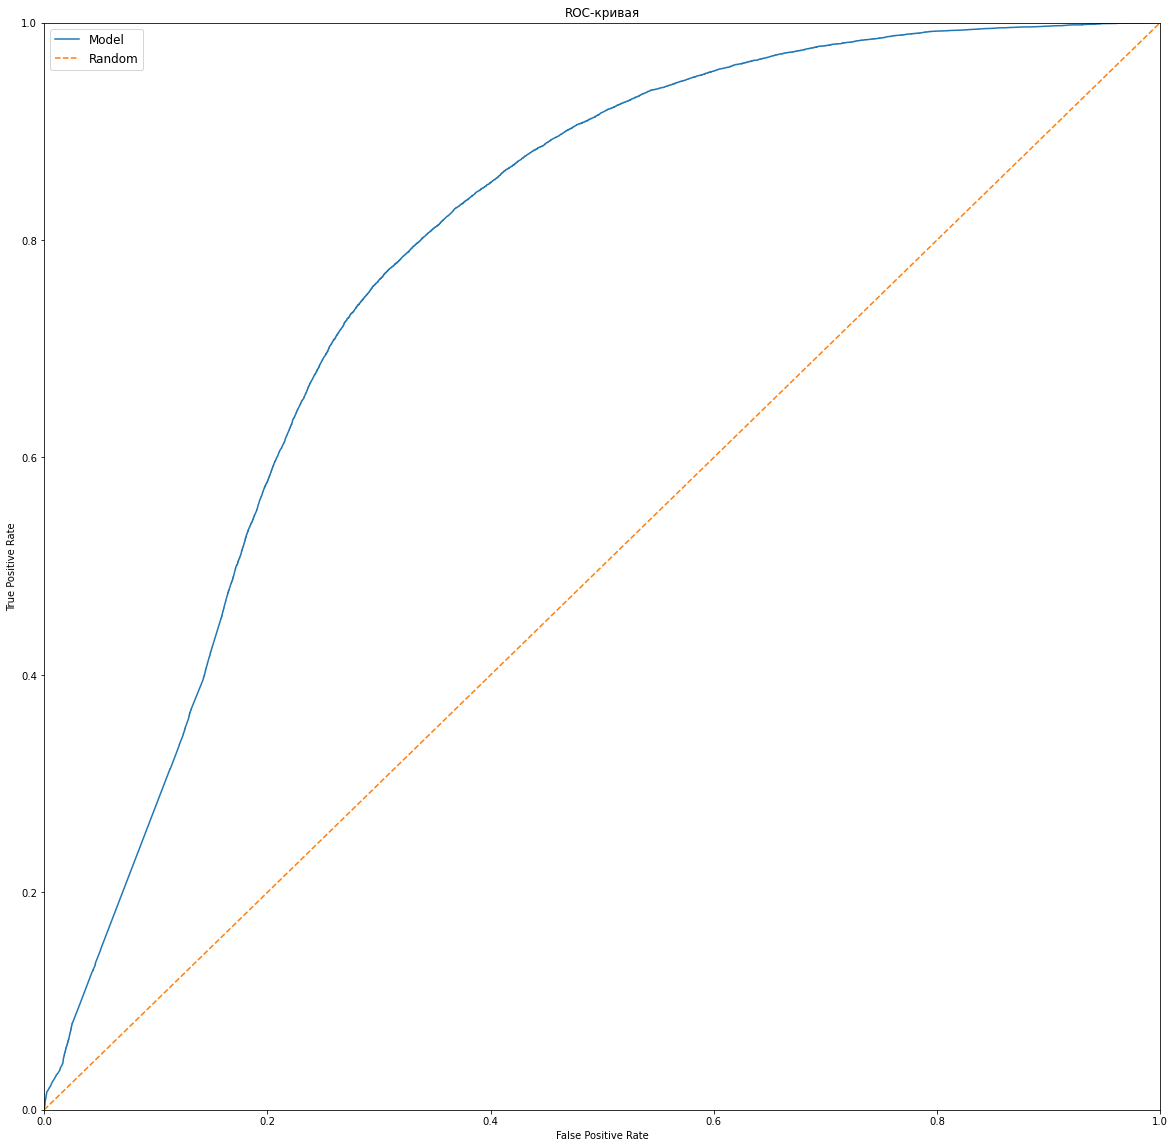

auc_roc = 0.7313205020860664


In [72]:
plt_roc_curve(lgbm_clf, X_test, y_test)

**Вывод:** На тестовой выборке обе модели показывают практически одинаковую метрику качества ROC-AUC=0.73. Окончательный выбор стоит сделать в пользу модели LGBMClassifier, так как она работает значительно быстрее модели CatBoostClassifier при одинаковом качестве.

### 4.2 Проверка важности признаков

Проанализируем важность признаков с помощью библиотеки Shap, и с помощью метода feature_importances_.

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


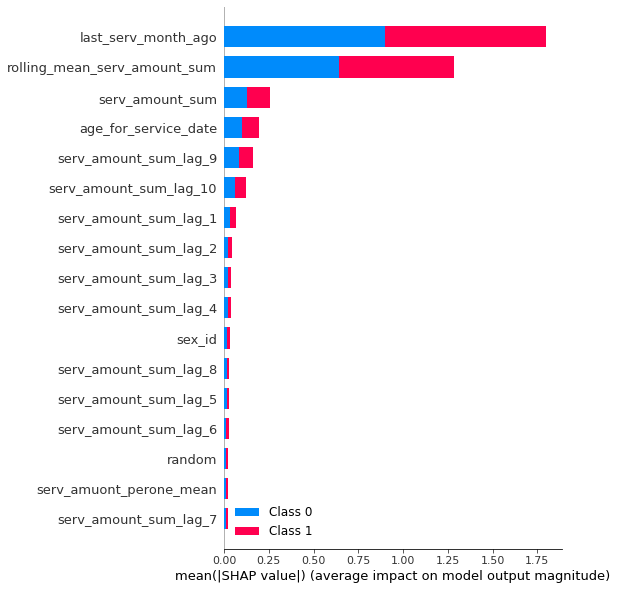

In [73]:
shap_test = shap.TreeExplainer(lgbm_clf).shap_values(X_train)
shap.summary_plot(shap_test, X_train, max_display=20, auto_size_plot=True)

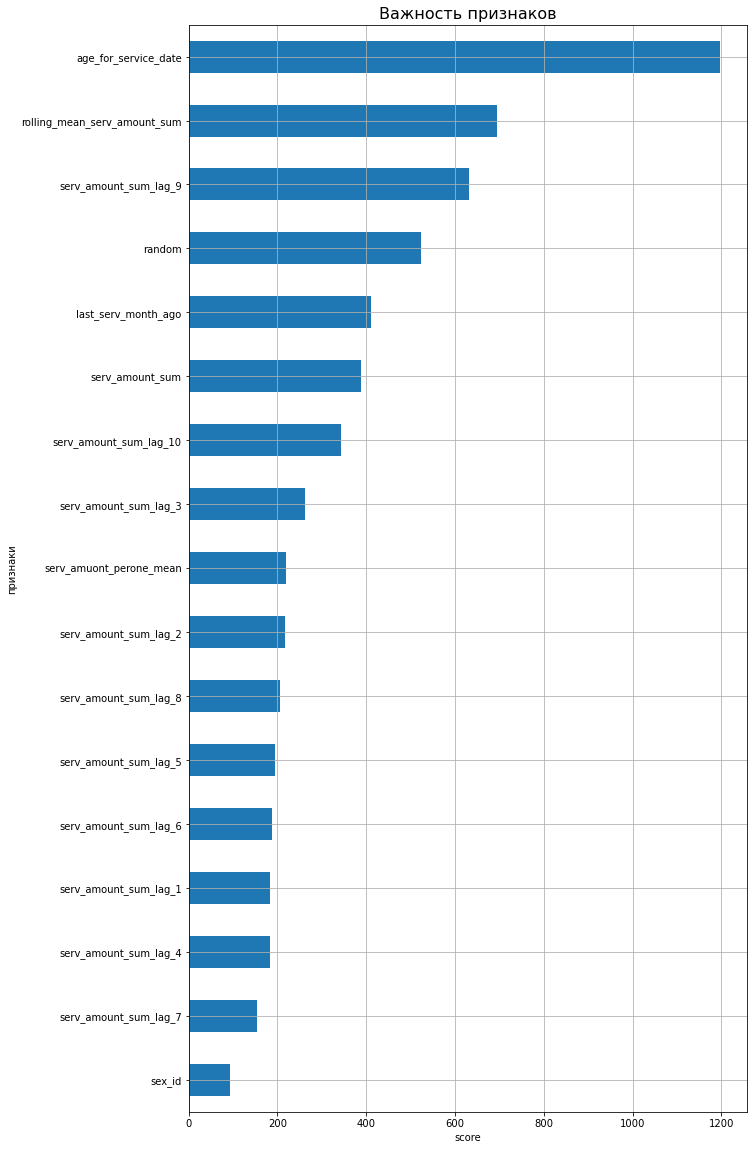

In [74]:
# Выделим признаки
efectiv_score = pd.DataFrame(data={'score': lgbm_clf.feature_importances_}, 
                            index=X_train.columns).sort_values(by='score')
# Выведем их на экран
ax = efectiv_score.plot(kind='barh', grid=True, figsize=(10,20), legend=False)
ax.set_title("Важность признаков", fontsize=16)
ax.set_ylabel("признаки")
ax.set_xlabel("score")
plt.show;

**Вывод:** 
Оба метода оценки признаков выдают схожие данные о важности признаков. 
Наиболее важные признаки:
- `last_serv_month_ago` - количество месяцев с момента последнего обращения,
- `rolling_mean_serv_amount_sum` - скользящее среднее суммарной цены услуг в месяц,
- `serv_amount_sum_lag_9` - суммарная цена оказанных услуг 9 месяцев назад;
- `age_for_service_date` - возраст застрахованного.

## 4.3 Проверка работы модели на адекватность

Сравним работу модели с работой фиктивной модели.

In [75]:
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)
dummy_predict = dummy_model.predict(X_test)
roc_auc_score(y_test, dummy_predict)

0.5

**Вывод:** ROC-AUC фиктивной модели = 0.5 - наша модель явно лучше!

### 4.4 Сохранение результатов

В сохраняемом файле будут содержаться:
- `id` - ид застрахованного
- `label` - предсказанные значения целевого признака
- `true_label` - истинными значения целевого признака

In [78]:
df_submission = pd.DataFrame({'id': df_final[df_final['label'] == 9999]['insured'].values,
                               'label': predict,
                               'true_label':y_test
                             })
df_submission.head()

,id,label,true_label
11,125045.0,1,1
24,125046.0,1,0
37,125047.0,0,0
50,125048.0,1,1
63,125049.0,1,0


In [79]:
df_submission.to_csv("Test_task_submission.csv", index=False)

**Вывод:** Результаты работы модели на тестовой выборке сохранены.

**Вывод по разделу**

1. Работа модели проверена на тестовой выборке. Считаю что результат вполне удовлетворительный. Метрика ROC-AUC = 0.73. Что на 0.23 лучше, чем показывает фиктивная модель. 
2. Важность признаков, в целом, коррелирует с предыдущими выводами. 
3. Результаты работы модели на тестовой выборке сохранены.

# Общий вывод



1. На этапе Анализа данных произвели загрузку данных и их анализ. Выяснили проблемные вопросы и наметили пути их решения. Так-же возник ряд вопросов, которые  стоило-бы задать владельцу данных или лицу ответственному за сбор датасета.
2. На этапе подготовки данных была произведена их предобработка, выделение дополнительных признаков и формирование целевого признака. Затем данные были преобразованы в более удобный вид для анализа временных рядов по каждому клиенту - по оказанным услугам за каждый месяц. Далее, из начального набора данных был сформирован датасет с извлечёнными признаками временных рядов: сдвигов и скользящего среднего. Эксперементально было определено, что качество модели возрастает с ростом максимального сдвига и окна скользящего среднего. В результате всех преобразований, данные с января по ноябрь 2021 года были использованы в качестве обучающих, а данные с февраля по декабрь 2021 в качестве тестовых. На основе данных с марта 2021 года по январь 2022 года могут быть использованы для прогнозирования обращений на февраль 2022 года.
3. На этапе обучения модели, были обучены несколько моделей, произведён подбор гиперпараметров к ним. Наилучшее качество показали модели основанные на деревьях. Для тестирования выбраны модели LigtGBMClassifier и CatBoostClassifier.
4. На этапе проверки модели, была произведена проверка работы двух моделей на тестовой выборке, с результатом у обоих ROC-AUC=0.73, что на 0.23 лучше случайной и константной модели. Окончательный выбор модели следует сделать в пользу LigtGBMClassifier, так как при одинаковом качестве работы, она работает гораздо быстрее. Далее, была произведена оценка важности признаков и сравнение работы модели с фиктивной моделью.
5. Думаю, что с представленными данными качество модели сильно увеличить не удастся. Для дальнейшего увеличения качества модели необходимо добавление в датасет дополнительных данных. Например данных о болезнях застрахованных, причинах их обращений за медицинской помощью, принимаемых ими препаратах и т.д.

## Сравнение модели с моделью из первого тестового задания

Несмотря на то, что метрика качества на тестовой выборке здесь получилась несколько хуже(0.73 против 0.76), модель получилась немного лучше. Это связано с тем, что в предыдущем проекте модель обучалась на на данных с января по декабрь 2021 года и с таргетом на данных января 2022 года. Тестовая выборка была не весь январь, а лишь 20% января. Если протестировать вновь созданную модель в таких условиях, она показывает качество = 0.81.